In [1]:
#-- YOLO World and DINO --

In [2]:
#-- Install ultralytics for YOLO World --------------------------------------------------------------------------
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()
#---------------------------------------------------------------------------------------------------------------

Ultralytics YOLOv8.2.27 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5643.4/8062.4 GB disk)


In [3]:
#-- Install GroundingDINO  ----------------------------------------------------------------------------------------
%cd /kaggle/working/  

!git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd GroundingDINO/
!pip install -e .

!mkdir weights
%cd weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

%cd /kaggle/working/GroundingDINO    

#-- clear output --
from IPython import display
display.clear_output()  

!python -c "import groundingdino" && echo "Module installed successfully" || echo "Module installation failed"
#---------------------------------------------------------------------------------------------------------------

Module installed successfully


In [4]:
#-- Import -----------------------------------------------------------------------------------------------
%cd /kaggle/working/GroundingDINO
from groundingdino.util.inference import load_model as dn_load_model
from groundingdino.util.inference import load_image as dn_load_image
from groundingdino.util.inference import predict as dn_predict
from groundingdino.util.inference import annotate as dn_annotate
%cd /kaggle/working

from ultralytics import YOLO

import torch

import os
import shutil

import PIL
import cv2

import matplotlib.pyplot as plt

import random
#---------------------------------------------------------------------------------------------------------------

/kaggle/working/GroundingDINO
/kaggle/working


In [5]:
#-- Initialize ---------------------------------------------------------------------------------------------------
out_path = '/kaggle/working/'
images_dir = '/kaggle/input/zsod-test-images/'
lbls_file = '/kaggle/input/all-labels/all_labels.txt'

dino_model_config_file = out_path + 'GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
dino_model_weights_file = out_path + 'GroundingDINO/weights/groundingdino_swint_ogc.pth'

dino_results = out_path + 'dino_results/'

yolo_croped_dir = out_path + 'yolo_croped/'
dino_croped_dir = out_path + 'dino_croped/'
merged_croped_dir = out_path + 'merged_croped/'

YOLO_CONF_THRESHOLD = 0.1
YOLO_IOU_THRESHOLD = 0.5

DINO_BOX_THRESHOLD = 0.25
DINO_TEXT_THRESHOLD = 0.1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:' , DEVICE)
#-----------------------------------------------------------------------------------------------------------------

device: cuda


In [6]:
#-- Create Dir for saving Results ---------------------------------------------------------------------------------
os.makedirs(dino_results, exist_ok=True)
os.makedirs(yolo_croped_dir, exist_ok=True)
os.makedirs(dino_croped_dir, exist_ok=True)
os.makedirs(merged_croped_dir, exist_ok=True)
#-----------------------------------------------------------------------------------------------------------------

In [7]:
#-- Load all labels -----------------------------------------------------------------------------------------------
all_labels = set()
with open(lbls_file, "r") as file:
    for line in file:            
        lbl = line.strip().lower()
        all_labels.add(lbl)   

print('number of all labels:' , len(all_labels))

yolo_all_labels = list(all_labels)

dino_all_labels = ''
for lbl in all_labels:
    dino_all_labels += lbl + ', '
#-----------------------------------------------------------------------------------------------------------------

number of all labels: 1873


In [8]:
#-- Run YOLO-World  ---------------------------------------------------------------------------------------------------
#-- Create Model --
model = YOLO('yolov8x-worldv2.pt')
display.clear_output()

#-- Set Custome Classes --
model.set_classes(yolo_all_labels)

#-- Run Model to Predict Objects --
project_value = 'yolo_world_results'
name_value = 'predictions'        

#-- key: image file --
yolo_all_objects_bbox = {}
yolo_number_of_all_objects = {}
yolo_number_of_classes = {}
yolo_number_of_objs_per_class = {}

for image_name in os.listdir(images_dir):
    
    image_path = os.path.join(images_dir, image_name)
    
    #-- Run prediction on the current image --
    results = model.predict(source=image_path,
                            conf=YOLO_CONF_THRESHOLD,
                            iou=YOLO_IOU_THRESHOLD,
                            show=False,
                            save=True,
                            project=project_value,
                            name=name_value,
                            exist_ok=True)
    
    #-- Extract labels and bounding boxes for the current image --
    labels_and_boxes = []
    img_n_all_objs = 0
    img_n_objs_per_cls = {}
    
    for result in results:
        for box in result.boxes:
            class_id = int(box.cls)  
            label = yolo_all_labels[class_id]           
            bbox = box.xywhn.tolist() #center_x, center_y, width, height
            labels_and_boxes.append({
                "label": label,
                "bbox": bbox[0]
            })            
            
            img_n_all_objs += 1
            
            #-- Count objects per class in the current image --
            if label in img_n_objs_per_cls:
                img_n_objs_per_cls[label] += 1
            else:
                img_n_objs_per_cls[label] = 1
    
    
    yolo_all_objects_bbox[image_name] = labels_and_boxes    
    yolo_number_of_all_objects[image_name] = img_n_all_objs
    yolo_number_of_classes[image_name] = len(img_n_objs_per_cls)
    yolo_number_of_objs_per_class[image_name] = img_n_objs_per_cls

display.clear_output()
print('Finished Predicting :)')
#-----------------------------------------------------------------------------------------------------------------

Finished Predicting :)


Image: img (9).jpg ===========================================================


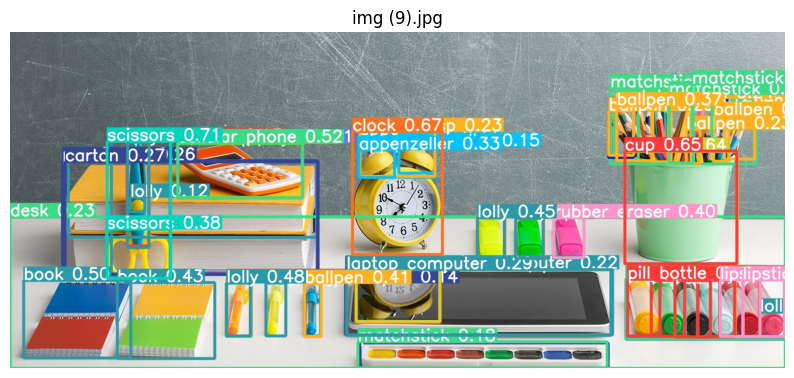

Total Objects: 78
Total Classes: 32
Objects per Class: {'scissors': 2, 'clock': 2, 'cup': 1, 'bucket': 1, 'lipstick': 3, 'cellular phone': 1, 'book': 3, 'lolly': 12, 'pill bottle': 4, 'mobile phone': 1, 'ballpen': 9, 'cassette player': 1, 'rubber eraser': 3, 'matchstick': 7, 'appenzeller': 4, 'cell': 2, 'laptop computer': 1, 'pop bottle': 4, 'carton': 1, 'pencil box': 2, 'lighter': 3, 'horned asp': 1, 'desk': 1, 'notebook': 1, 'hand-held microcomputer': 1, 'cathode-ray oscilloscope': 1, 'analog clock': 1, 'screwdriver': 1, 'fountain pen': 1, 'letter opener': 1, 'quill pen': 1, 'xylophone': 1}
  Label: scissors, Bounding Box: [0.16610676050186157, 0.5303894281387329, 0.08208131790161133, 0.40536847710609436]
  Label: clock, Bounding Box: [0.4999648332595825, 0.4802647829055786, 0.11549017578363419, 0.36438727378845215]
  Label: cup, Bounding Box: [0.8658249378204346, 0.5238729119300842, 0.1444309651851654, 0.33424484729766846]
  Label: bucket, Bounding Box: [0.8658527135848999, 0.524338

In [9]:
#-- Display YOLO-World Results ------------------------------------------------------------------------------------
for image_name, labels_and_boxes in yolo_all_objects_bbox.items():
    
    print(f'Image: {image_name} ===========================================================')
    
    predicted_image_path = os.path.join(project_value, name_value, image_name)
    img = PIL.Image.open(predicted_image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_name)
    plt.show()
    
    
    print(f'Total Objects: {yolo_number_of_all_objects[image_name]}')
    print(f'Total Classes: {yolo_number_of_classes[image_name]}')
    print(f'Objects per Class: {yolo_number_of_objs_per_class[image_name]}')    
    for item in labels_and_boxes:
        print(f"  Label: {item['label']}, Bounding Box: {item['bbox']}")
        
    break
    
    
#-----------------------------------------------------------------------------------------------------------------

In [10]:
#-- Crop Objects using Box --------------------------------------------------------------
def crop_object(image, x_center, y_center, width, height):
    # Calculate coordinates of bounding box
    left = int((x_center - width / 2) * image.shape[1])
    top = int((y_center - height / 2) * image.shape[0])
    right = int((x_center + width / 2) * image.shape[1])
    bottom = int((y_center + height / 2) * image.shape[0])

    # Crop the object
    cropped_object = image[top:bottom, left:right]

    return cropped_object
#-----------------------------------------------------------------------------------------------------------------

Image: img (9).jpg ===========================================================


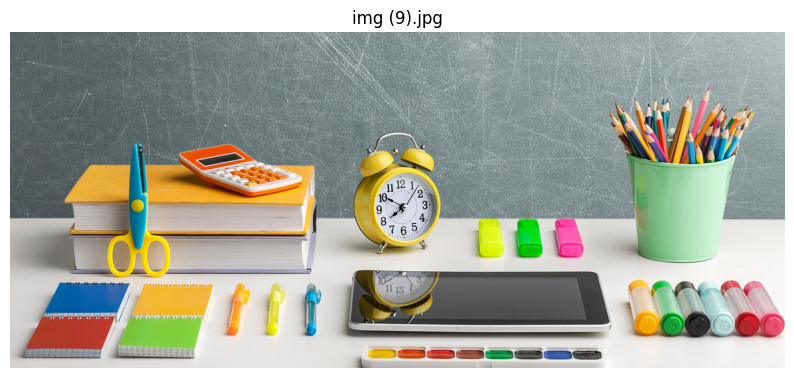

0.16610676050186157 0.5303894281387329 0.08208131790161133 0.40536847710609436


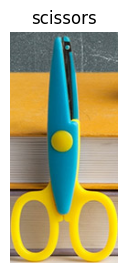

In [11]:
#-- Crop Deteccted Objects ----------------------------------------------------------------------------------
for image_name, labels_and_boxes in yolo_all_objects_bbox.items():
    
    print(f'Image: {image_name} ===========================================================')
    
    predicted_image_path = os.path.join(images_dir, image_name)
    img = cv2.imread(predicted_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_name)
    plt.show()   
     
    n = 0
    for item in labels_and_boxes:
        n += 1
        
#         print(f"  Label: {item['label']}, Bounding Box: {item['bbox']}")
        x_center, y_center, width, height = item['bbox'][0], item['bbox'][1], item['bbox'][2], item['bbox'][3]
        print(x_center, y_center, width, height)
        
        cropped_object = crop_object(img, x_center, y_center, width, height)
        plt.figure(figsize=(3, 3))
        plt.imshow(cropped_object)
        plt.axis('off')
        plt.title(item['label'])
        
        dot_index = image_name.rfind('.')        
        file_name = f"{image_name[:dot_index]}_{n}_{item['label']}.png"
        plt.savefig(yolo_croped_dir + file_name)
        plt.show()      
        
        break
    break
        
    
    
#-----------------------------------------------------------------------------------------------------------------

In [12]:
#-- Plot BBoxes for DINO ----------------------------------------------------------------------------------------
def plot_boxes(image, boxes, logits, phrases):
    
    annotated_img = dn_annotate(image_source=image,
                                    boxes=boxes,
                                    logits=logits,
                                    phrases=phrases)
        
    out_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)        
    plt.imshow(out_img, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])        
    plt.show()  
    
    return out_img
#-----------------------------------------------------------------------------------------------------------------

In [13]:
#-- Run DINO -----------------------------------------------------------------------------------------------------
#-- Create Model --
model_dino = dn_load_model(dino_model_config_file,
                           dino_model_weights_file,
                           device= DEVICE)

#-- create dino_results folder --
os.makedirs(dino_results, exist_ok=True)

#-- key: image file --
dino_all_objects_bbox = {}
dino_number_of_all_objects = {}
dino_number_of_classes = {}
dino_number_of_objs_per_class = {}

for image_name in os.listdir(images_dir):
    
    image_path = os.path.join(images_dir, image_name)
    
    #-- load image --
    image_source, image = dn_load_image(image_path)
    
    #-- predict on images --
    boxes, logits, phrases = dn_predict(model = model_dino,
                                        image = image,
                                        caption = dino_all_labels,
                                        box_threshold = DINO_BOX_THRESHOLD,
                                        text_threshold = DINO_TEXT_THRESHOLD)
    #-- annotate image with bbox --
    annotated_img = dn_annotate(image_source=image_source,
                                boxes=boxes,
                                logits=logits,
                                phrases=phrases)        
    #-- save result --
    result_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)     
    cv2.imwrite(dino_results + image_name, result_img)
    
    labels_and_boxes = []
    img_n_all_objs = 0
    img_n_objs_per_cls = {}
    
    for bbox, phrase in zip(boxes, phrases):        
        label = phrase #phrase.split(' ')[0]             
        labels_and_boxes.append({
                "label": label,
                "bbox": bbox.tolist() #-- center_x, center_y, width, height --
            })        
        
        img_n_all_objs += 1    
        
        #-- Count objects per class in the current image --
        if label in img_n_objs_per_cls:
            img_n_objs_per_cls[label] += 1
        else:
            img_n_objs_per_cls[label] = 1
        
        
    
    dino_all_objects_bbox[image_name] = labels_and_boxes    
    dino_number_of_all_objects[image_name] = img_n_all_objs
    dino_number_of_classes[image_name] = len(img_n_objs_per_cls)
    dino_number_of_objs_per_class[image_name] = img_n_objs_per_cls
    
    

display.clear_output()
print('Finished Predicting :)')
#-----------------------------------------------------------------------------------------------------------------

Finished Predicting :)


Image: img (9).jpg ===========================================================


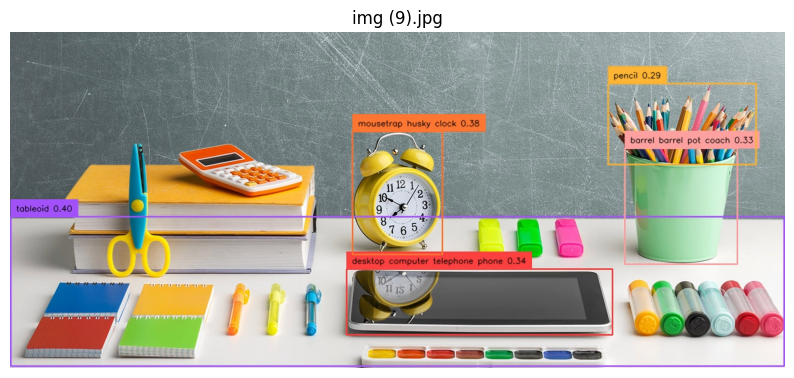

Total Objects: 5
Total Classes: 5
Objects per Class: {'tableoid': 1, 'desktop computer telephone phone': 1, 'barrel barrel pot coach': 1, 'mousetrap husky clock': 1, 'pencil': 1}
  Label: tableoid, Bounding Box: [0.5001115202903748, 0.7729300856590271, 0.9981531500816345, 0.4435661733150482]
  Label: desktop computer telephone phone, Bounding Box: [0.6057093143463135, 0.8042681813240051, 0.3427828252315521, 0.1949663758277893]
  Label: barrel barrel pot coach, Bounding Box: [0.8661615252494812, 0.5196124911308289, 0.145204558968544, 0.3433980345726013]
  Label: mousetrap husky clock, Bounding Box: [0.49997949600219727, 0.48057445883750916, 0.1159905344247818, 0.36457911133766174]
  Label: pencil, Bounding Box: [0.867325484752655, 0.27570879459381104, 0.19132903218269348, 0.24064987897872925]


In [14]:
#-- Display DINO Results ------------------------------------------------------------------------------------
for image_name, labels_and_boxes in dino_all_objects_bbox.items():
    
    print(f'Image: {image_name} ===========================================================')
    
    predicted_image_path = os.path.join(dino_results, image_name) 
    img = cv2.imread(predicted_image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_name)
    plt.show()
    
    
    print(f'Total Objects: {dino_number_of_all_objects[image_name]}')
    print(f'Total Classes: {dino_number_of_classes[image_name]}')
    print(f'Objects per Class: {dino_number_of_objs_per_class[image_name]}')    
    for item in labels_and_boxes:
        print(f"  Label: {item['label']}, Bounding Box: {item['bbox']}")
    
    break
    
     
#-----------------------------------------------------------------------------------------------------------------

Image: img (9).jpg ===========================================================


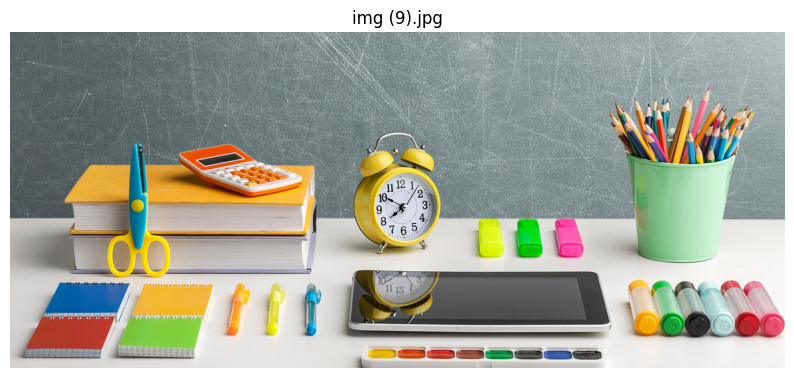

0.5001115202903748 0.7729300856590271 0.9981531500816345 0.4435661733150482


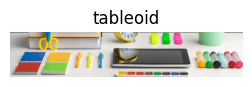

In [15]:
#-- Crop Detected Objects  ------------------------------------------------------------------------------------
for image_name, labels_and_boxes in dino_all_objects_bbox.items():
    
    print(f'Image: {image_name} ===========================================================')
    
    predicted_image_path = os.path.join(images_dir, image_name)
    img = cv2.imread(predicted_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_name)
    plt.show()   
     
    n = 0
    for item in labels_and_boxes:
        n += 1
        
#         print(f"  Label: {item['label']}, Bounding Box: {item['bbox']}")
        x_center, y_center, width, height = item['bbox'][0], item['bbox'][1], item['bbox'][2], item['bbox'][3]
        print(x_center, y_center, width, height)
        
        cropped_object = crop_object(img, x_center, y_center, width, height)
        plt.figure(figsize=(3, 3))
        plt.imshow(cropped_object)
        plt.axis('off')
        plt.title(item['label'])
        
        dot_index = image_name.rfind('.')        
        file_name = f"{image_name[:dot_index]}_{n}_{item['label']}.png"
        plt.savefig(dino_croped_dir + file_name)
        plt.show()      
        
        break
    break
        
    
    
#-----------------------------------------------------------------------------------------------------------------

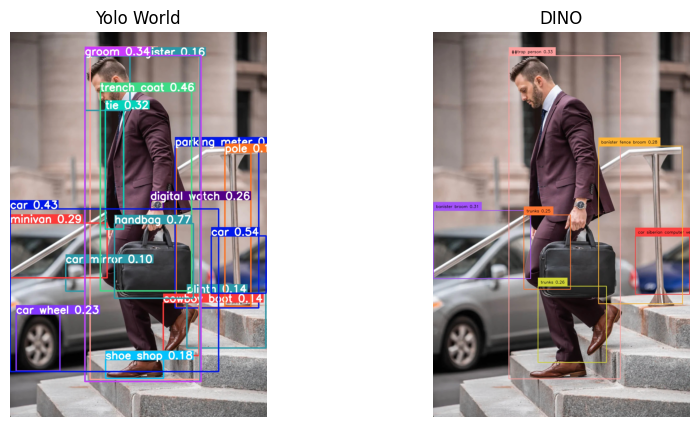

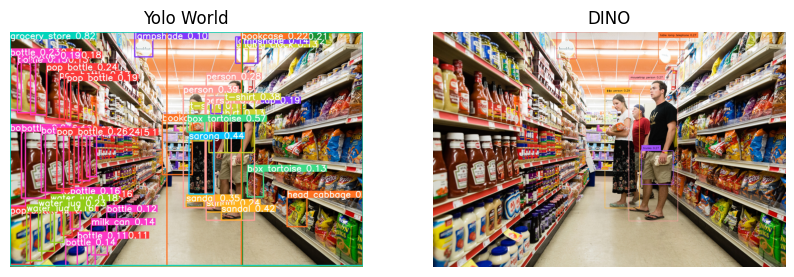

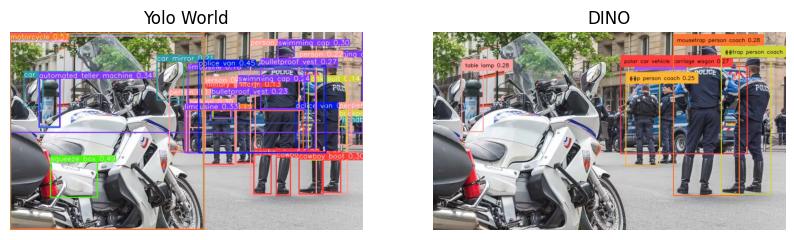

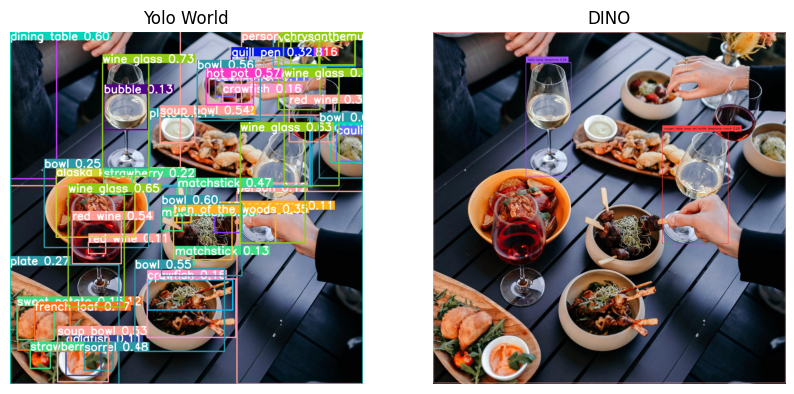

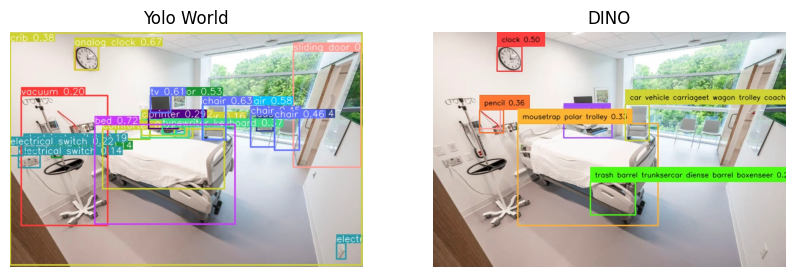

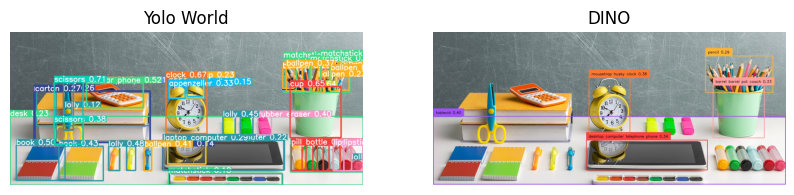

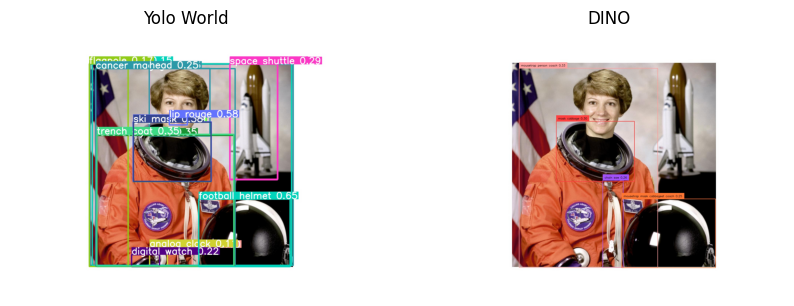

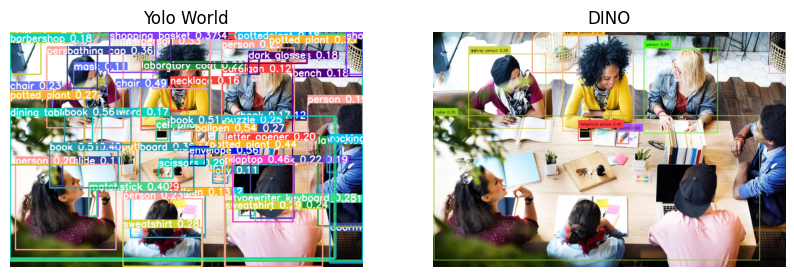

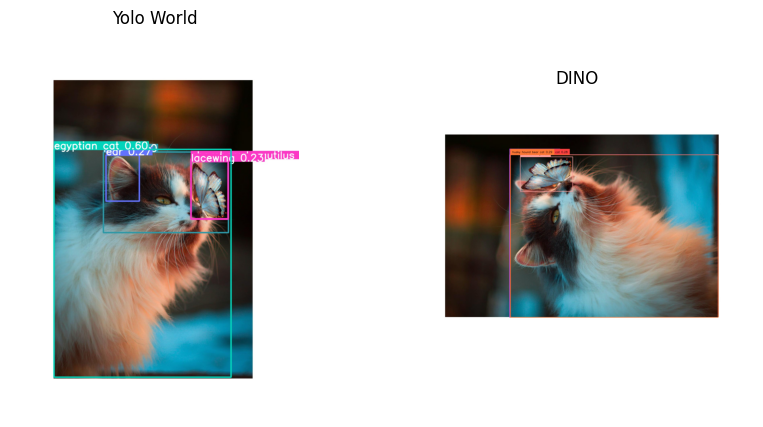

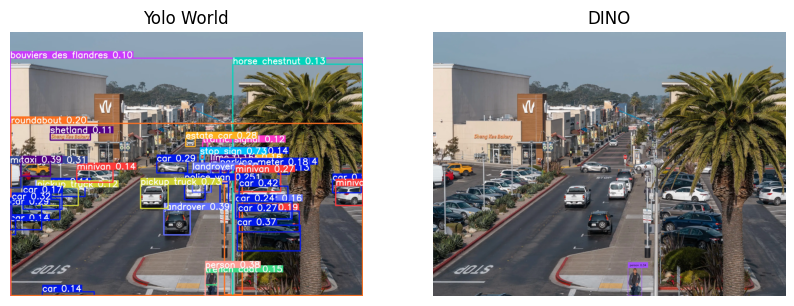

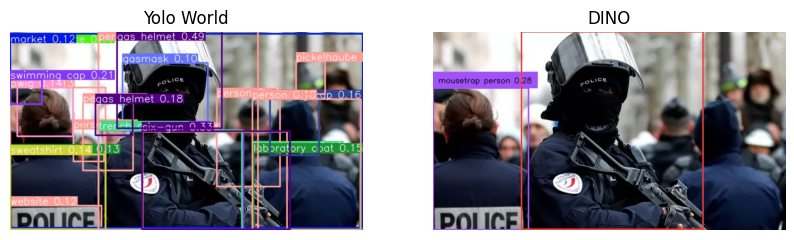

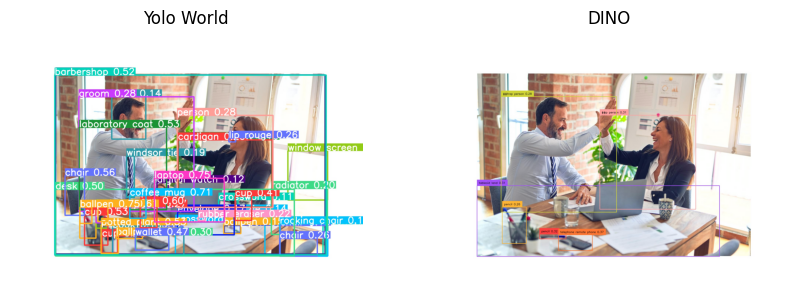

In [16]:
#-- Plot and Compare Results --------------------------------------------------------------------------------------
yolo_results_dir = '/kaggle/working/yolo_world_results/predictions/'
dino_results_dir = '/kaggle/working/dino_results/'

result_image_files = [f for f in os.listdir(yolo_results_dir)]  

for img_file in result_image_files:    
    
    img_yolo = cv2.imread(yolo_results_dir + img_file)
    img_yolo = cv2.cvtColor(img_yolo, cv2.COLOR_BGR2RGB)     
    img_dino = cv2.imread(dino_results_dir + img_file)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
       
    axs[0].imshow(img_yolo)
    axs[0].set_title('Yolo World')
    axs[0].axis('off')
       
    axs[1].imshow(img_dino)
    axs[1].set_title('DINO')
    axs[1].axis('off')
       
    plt.show()
#-----------------------------------------------------------------------------------------------------------------

In [17]:
#-- Convert Boxes -------------------------------------------------------------------------------
def convert_to_corners(box):
    """
    Convert bounding box from center format (center_x, center_y, width, height)
    to corner format (x1, y1, x2, y2)
    where where (x1, y1) is the top-left corner and (x2, y2) is the bottom-right corner.    
    """
    
    center_x, center_y, width, height = box
    x1 = center_x - width / 2
    y1 = center_y - height / 2
    x2 = center_x + width / 2
    y2 = center_y + height / 2
    return [x1, y1, x2, y2]
#-----------------------------------------------------------------------------------------------------------------

In [18]:
#-- Compute IOU for 2 Objects -----------------------------------------------------------------------------------
def compute_iou(box1, box2):
    
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    
    x1_intersection = max(x1_1, x1_2)
    y1_intersection = max(y1_1, y1_2)
    x2_intersection = min(x2_1, x2_2)
    y2_intersection = min(y2_1, y2_2)

   
    intersection_area = max(0, x2_intersection - x1_intersection + 1) * max(0, y2_intersection - y1_intersection + 1)    
    box1_area = (x2_1 - x1_1 + 1) * (y2_1 - y1_1 + 1)
    box2_area = (x2_2 - x1_2 + 1) * (y2_2 - y1_2 + 1)    
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area

    return iou
#-----------------------------------------------------------------------------------------------------------------

In [19]:
#-- merge detected objects using iou ------------------------------------------------------------------------------
def merge_objects(image, yolo_objects, dino_objects, iou_threshold):
    
    merged_objcs = []
    matched_indices = set()

    for yolo_obj in yolo_objects:
        yolo_box = yolo_obj['bbox']
        yolo_lbl = yolo_obj['label']
        
        merged = False
        yolo_box_corners = convert_to_corners(yolo_box)
        
        for i, dino_obj in enumerate(dino_objects):
            dino_box =  dino_obj['bbox']           
            
            if i in matched_indices:
                continue
                
            dino_box_corners = convert_to_corners(dino_box)
            iou = compute_iou(yolo_box_corners, dino_box_corners)
            
            if iou >= iou_threshold:
                merged_box_corners = [
                    min(yolo_box_corners[0], dino_box_corners[0]),  # x1
                    min(yolo_box_corners[1], dino_box_corners[1]),  # y1
                    max(yolo_box_corners[2], dino_box_corners[2]),  # x2
                    max(yolo_box_corners[3], dino_box_corners[3])   # y2
                ]
                center_x = (merged_box_corners[0] + merged_box_corners[2]) / 2
                center_y = (merged_box_corners[1] + merged_box_corners[3]) / 2
                width = merged_box_corners[2] - merged_box_corners[0]
                height = merged_box_corners[3] - merged_box_corners[1]
                
                merged_objcs.append({'label': yolo_lbl,
                                     'bbox': [center_x, center_y, width, height]})
                
                matched_indices.add(i)
                merged = True
                break
        if not merged:
            merged_objcs.append(yolo_obj)

    #-- Add remaining boxes from dino_objects that were not matched --
    for i, dino_obj in enumerate(dino_objects):
        if i not in matched_indices:
            merged_objcs.append(dino_obj)

    return merged_objcs   
#-----------------------------------------------------------------------------------------------------------------

Image: img (9).jpg ===========================================================


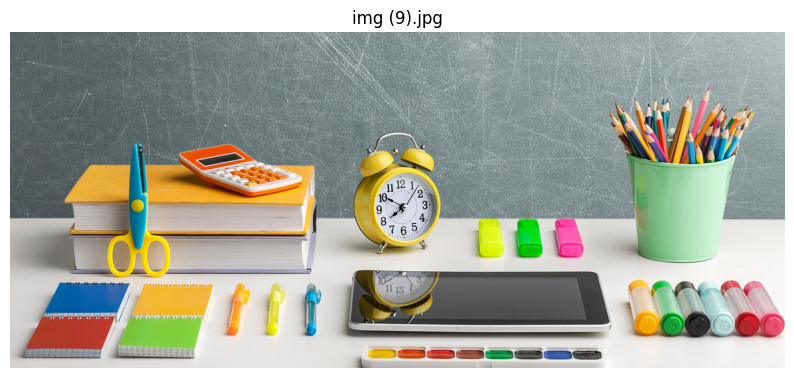

78
5
78


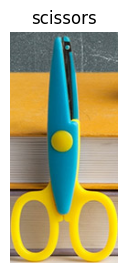

In [20]:
#-- Merge Detected Object brom YOLO_World and DINO -----------------------------------------------------------------
for image_name, yolo_labels_and_boxes in yolo_all_objects_bbox.items():
    
    print(f'Image: {image_name} ===========================================================')
    
    predicted_image_path = os.path.join(images_dir, image_name)
    img = cv2.imread(predicted_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(image_name)
    plt.show()   
    
    yolo_objects = yolo_labels_and_boxes    
    dino_objects = dino_all_objects_bbox[image_name]
    
    merged_objs = merge_objects(img, yolo_objects, dino_objects, iou_threshold=0.6)
    
    print(len(yolo_objects))
    print(len(dino_objects))
    print(len(merged_objs))
    
    n = 0
    for m_obj in merged_objs:
        n += 1                
        
        x_center, y_center, width, height = m_obj['bbox'][0], m_obj['bbox'][1], m_obj['bbox'][2], m_obj['bbox'][3]        
        cropped_object = crop_object(img, x_center, y_center, width, height)
        plt.figure(figsize=(3, 3))
        plt.imshow(cropped_object)
        plt.axis('off')
        plt.title(m_obj['label'])
        
        dot_index = image_name.rfind('.')        
        file_name = f"{image_name[:dot_index]}_{n}_{item['label']}.png"
        plt.savefig(merged_croped_dir + file_name)
        plt.show() 
        
        break
    break
    
    
    
    
#-----------------------------------------------------------------------------------------------------------------